In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd
import scipy.stats as stats
from scipy.stats import spearmanr

import downscale as down

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator

from scipy.stats import weibull_min
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

%run ../function/functions.ipynb

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Test diferents trhesholds for IMERG data in Veneto

In [2]:
name, yy_s, yy_e = 'Coast Level', 2001, 2017
# name, yy_s, yy_e = 'Low Level', 2001, 2014
# name, yy_s, yy_e = 'Medium Level', 2001, 2017
# name, yy_s, yy_e = 'High Level', 2001, 2022

maxmiss = 40

In [3]:
npix = 5 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

thresh = 1 # default
# thresh = 2 
# thresh = 2.6 
# thresh = 3
# thresh = 4 
# thresh = 5 
# thresh = 6 
# thresh = 7
# thresh = 8

res = {} # Output dictionary with all information

In [4]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 477MB
Dimensions:  (time: 49672, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 477MB 0.0 0.0 0.0 0.0 ... 3.49 6.59 4.64
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [6]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

In [7]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')

if os.path.exists(rain_dir):
    RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')
else:
    raise SystemExit(f"File not found: {rain_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Coast Level station


,dataora,valore,qualita,yy,mm,dd,hh
528403,2017-11-30 10:00:00,0.0,1.0,2017,0,30,10
528404,2017-11-30 10:30:00,0.0,1.0,2017,30,30,10
528405,2017-11-30 11:00:00,0.0,1.0,2017,0,30,11


In [8]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [9]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
OBS_ACUM = CL_RAIN['valore'].resample('D').sum()
OBS_1DY = pd.DataFrame({'PRE':OBS_ACUM.values, 'TIME':pd.to_datetime(OBS_ACUM.index)})

In [10]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

In [11]:
OBS_1dy_df = xr.DataArray(OBS_1DY['PRE'].values,  coords={'time':OBS_1DY['TIME'].values}, dims=('time'))
OBS_1dy_df = pd.DataFrame({'TIME':OBS_1dy_df['time'].data, 'PRCP':OBS_1dy_df.data})
OBS_1dy_df.shape

(6178, 2)

In [12]:
if len(OBS_1dy_df) < len(TIME_REF):
    print('WARNING: RAINGAUGE time is not complete. fill times with NaN')
    OBS_TMP = pd.merge(OBS_1dy_df, TIME_PD, on='TIME', how='right')
    OBS_xr = xr.DataArray(OBS_TMP['PRCP'].values,  coords={'time':OBS_TMP['TIME'].values}, dims=('time'))
elif len(OBS_1dy_df) == len(TIME_REF):
    print('GOOD: RAINGAUGE has certain times!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
else:
    print('ERROR: RAINGAUGE has too much times, verify!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
    print(f'OBS lenght : {len(OBS_1dy_df)}')
    print(f'TIME lenght: {len(TIME_REF)}')

In [13]:
OBS_NCW_1dy, OBS_YEARS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=maxmiss)
OBS_N, OBS_C, OBS_W = down.wei_fit(OBS_1dy_df.PRCP.values, 1)

In [14]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

TRMM_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


In [15]:
IMERG_pixel_3h = dset[:,min_index[0],min_index[1]] # time, lat, lon
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data

In [16]:
buffer = 0.5*npix*0.1 # To define the limitis of box_3h

In [17]:
# Original data 3h time resolution
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

del test

In [18]:
eps = 1e-4 # to make sure to include limtis -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [19]:
# Box 3h time resolution
box_3h = xrs.where(bcond, drop = True).load()

box_lon2d, box_lat2d = np.meshgrid(box_3h['lon'].data, box_3h['lat'].data)
nlon = len(box_3h['lon'].data)
nlat = len(box_3h['lat'].data)

if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

box_3h.shape

(5, 5, 49672)

In [20]:
# daily time resolution
xdaily0 = box_3h.resample(time ='{}h'.format(24)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

## Verify the difference between the wet days definitions

In [21]:
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

c_excesses1 = tsc
c_excesses2 = np.maximum(tsc-thresh, 0.0)
c_excesses3 = tsc[tsc > thresh]
c_excesses4 = tsc[tsc > thresh] - thresh

NCWy1, YEARSy1 = down.fit_yearly_weibull(c_excesses1, thresh=thresh, maxmiss=300)
NCWy2, YEARSy2 = down.fit_yearly_weibull(c_excesses2, thresh=thresh, maxmiss=300)
NCWy3, YEARSy3 = down.fit_yearly_weibull(c_excesses3, thresh=thresh, maxmiss=300)
NCWy4, YEARSy4 = down.fit_yearly_weibull(c_excesses4, thresh=thresh, maxmiss=300)

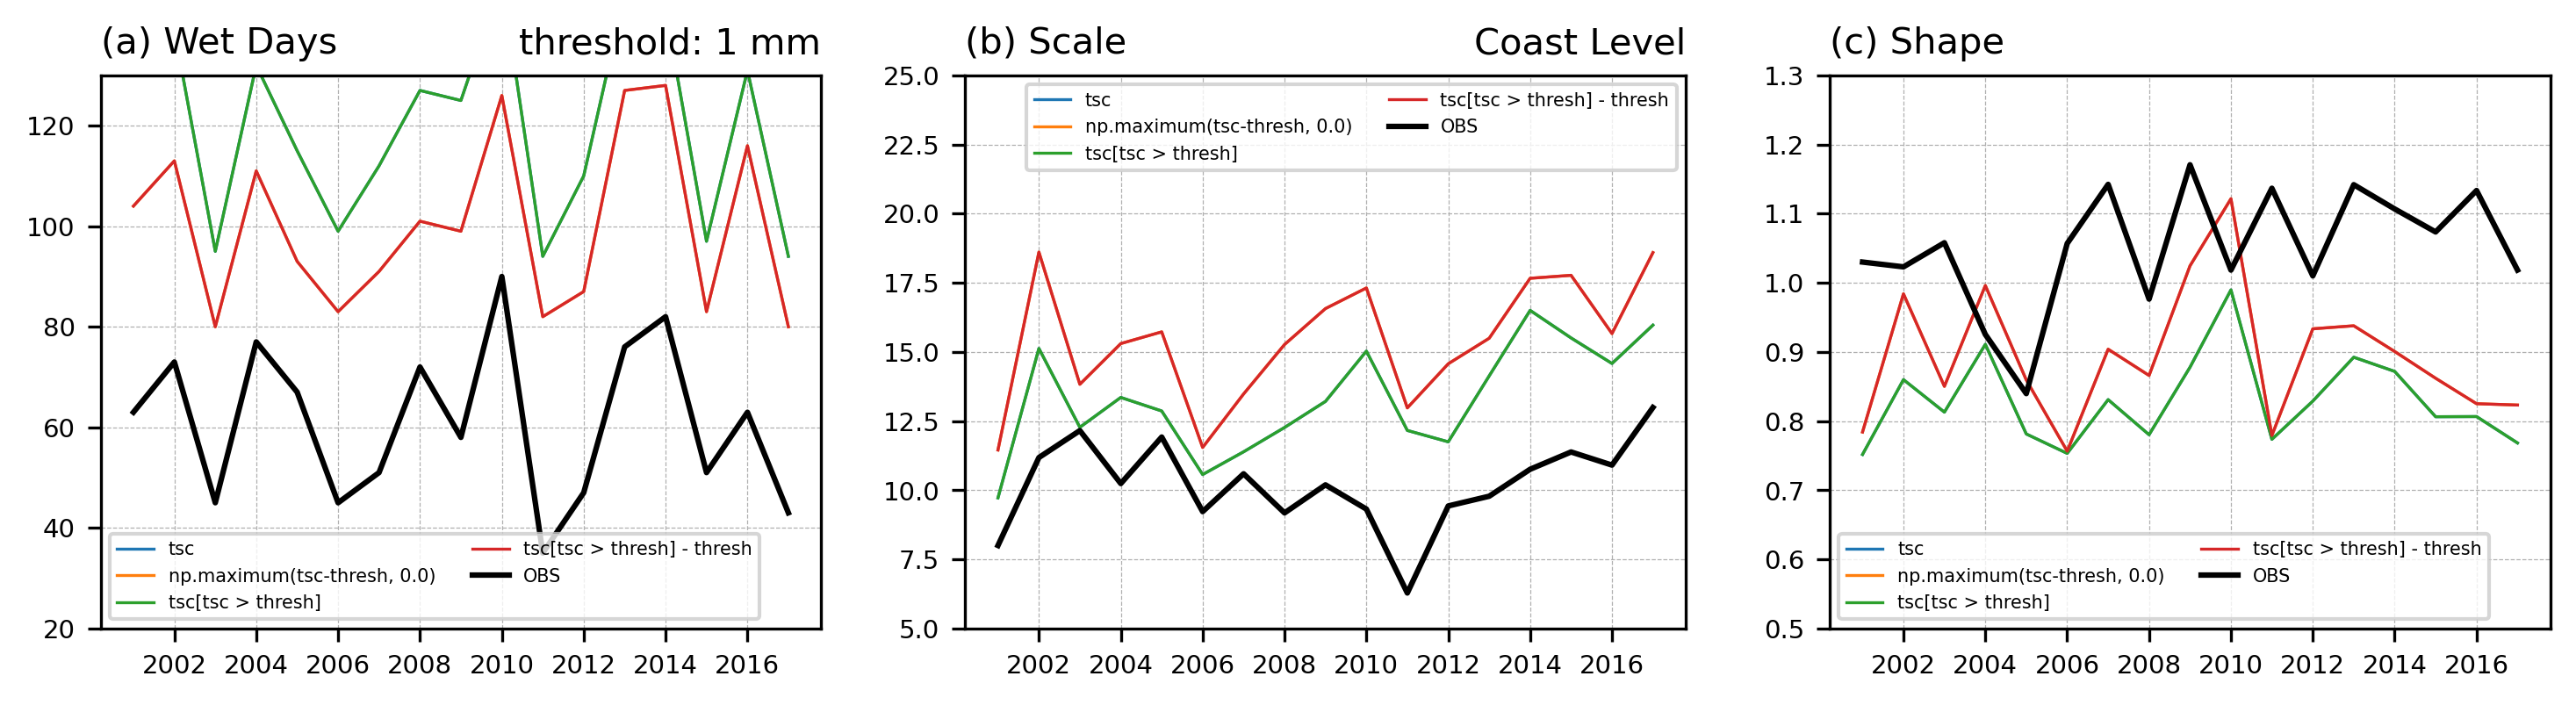

In [22]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(YEARSy1, NCWy1[:,0], linewidth=0.8, label='tsc')
ax1.plot(YEARSy2, NCWy2[:,0], linewidth=0.8, label='np.maximum(tsc-thresh, 0.0)')
ax1.plot(YEARSy3, NCWy3[:,0], linewidth=0.8, label='tsc[tsc > thresh]')
ax1.plot(YEARSy4, NCWy4[:,0], linewidth=0.8, label='tsc[tsc > thresh] - thresh')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.set_title(f'threshold: {thresh} mm', loc='right', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(20,130)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(YEARSy1, NCWy1[:,1], linewidth=0.8, label='tsc')
ax1.plot(YEARSy2, NCWy2[:,1], linewidth=0.8, label='np.maximum(tsc-thresh, 0.0)')
ax1.plot(YEARSy3, NCWy3[:,1], linewidth=0.8, label='tsc[tsc > thresh]')
ax1.plot(YEARSy4, NCWy4[:,1], linewidth=0.8, label='tsc[tsc > thresh] - thresh')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(b) Scale', loc='left', fontsize=10)
ax1.set_title(f'{name}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(5,25)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(YEARSy1, NCWy1[:,2], linewidth=0.8, label='tsc')
ax1.plot(YEARSy2, NCWy2[:,2], linewidth=0.8, label='np.maximum(tsc-thresh, 0.0)')
ax1.plot(YEARSy3, NCWy3[:,2], linewidth=0.8, label='tsc[tsc > thresh]')
ax1.plot(YEARSy4, NCWy4[:,2], linewidth=0.8, label='tsc[tsc > thresh] - thresh')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(c) Shape', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(0.5,1.3)
ax1.grid(linewidth=0.3, linestyle='--')

In [23]:
thrs_list = np.arange(1,4)

WD_thrs = []
SC_thrs = []
SH_thrs = []
YY_thrs = []
CC_thrs = []

for tt in thrs_list:
    print(f'Threshold: {tt} mm')

    tsc = xdaily.loc[dict(lat = clat, lon = clon)]
    c_excesses = tsc[tsc > tt]

    NCWy, YEARSy = down.fit_yearly_weibull(c_excesses, thresh=tt, maxmiss=300)
    WD_thrs.append(NCWy[:,0])
    SC_thrs.append(NCWy[:,1])
    SH_thrs.append(NCWy[:,2])
    YY_thrs.append(YEARSy)

Threshold: 1 mm
Threshold: 2 mm
Threshold: 3 mm


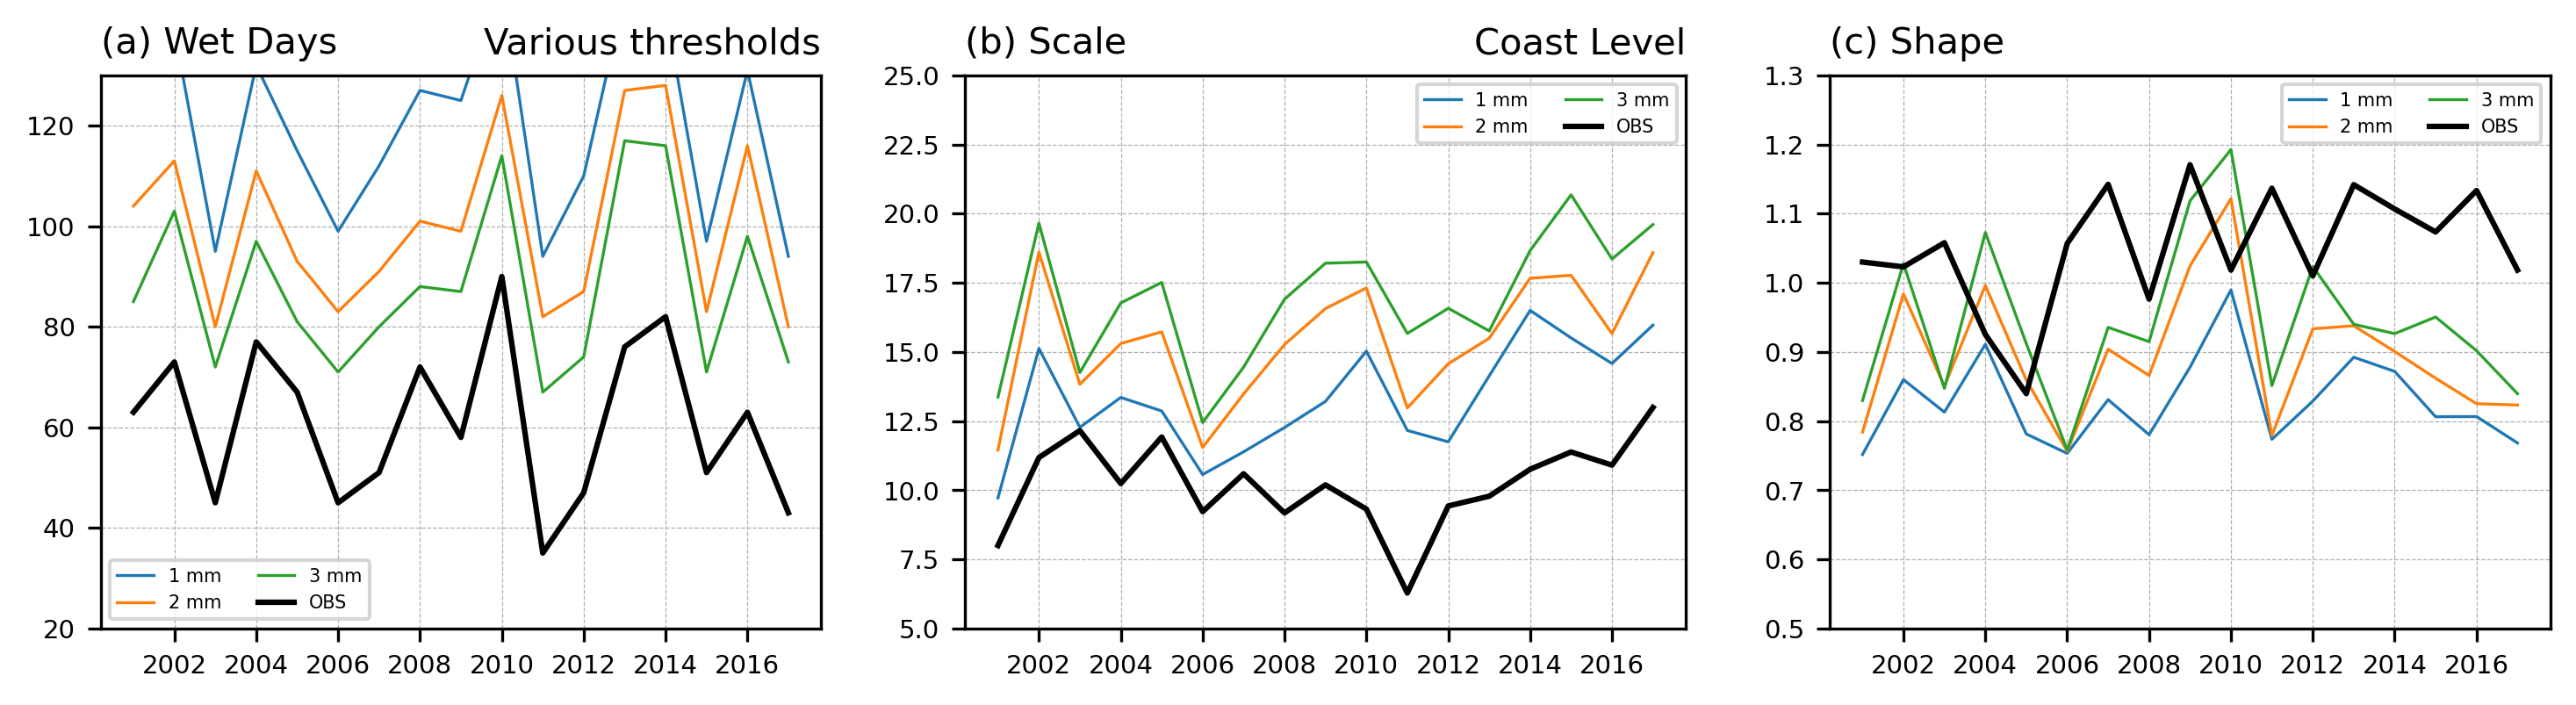

In [32]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
for nn in range(len(thrs_list)):
    ax1.plot(YY_thrs[nn], WD_thrs[nn], linewidth=0.8, label=f'{thrs_list[nn]} mm')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.set_title('Various thresholds', loc='right', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(20,130)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
for nn in range(len(thrs_list)):
    ax1.plot(YY_thrs[nn], SC_thrs[nn], linewidth=0.8, label=f'{thrs_list[nn]} mm')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(b) Scale', loc='left', fontsize=10)
ax1.set_title(f'{name}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(5,25)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
for nn in range(len(thrs_list)):
    ax1.plot(YY_thrs[nn], SH_thrs[nn], linewidth=0.8, label=f'{thrs_list[nn]} mm')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=2)
ax1.set_title('(c) Shape', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(0.5,1.3)
ax1.grid(linewidth=0.3, linestyle='--')